# 🎦**AlloCiné Recommender System**🔎📍

Once we cleaned the data, we can start to build our recommender system. The data that will be used is located in the `../Cleaned Data/` folder.

**Types of Recommender System:**

There are two types of recommender system: **`content-based`** and **`collaborative-filtering`**.

- **`Content-based`:** this recommender system is based only on the characteristics of the products. Here, we will recommend an item to a user by comparing the features between items and recommend the items with the highest similarity.

- **`Collaborative-filtering`:** this recommender system is based on the interactions between users and the items. 
    - `Memory-based`: Calculation of similarities between users or between products to recommend the right product.
        - `User-based CF`: Suggest products that have been well rated by similar users.
        - `Item-based CF`: Offer products that are well rated and similar to products already used.
    - `Model-based`: Finding a pattern explaining browsing and preferences behaviors.

By the format of our data, we will only be able to perform an `item-based CF` for the `memory-based` method as we don't have any information about the users, only their ratings and the features of the items.


---
# **Import libs**

In [158]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from ast import literal_eval
from warnings import filterwarnings
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop # Used to get the French stop-words
from IPython.display import clear_output

# We ignore dateparse warnings
filterwarnings("ignore",message="The localize method is no longer necessary, as this time zone supports the fold attribute")
# We ignore reindexing warnings
filterwarnings("ignore",message="Boolean Series key will be reindexed")
%matplotlib inline

# **Load the csv files**

In [159]:
def load_csv():
    '''
    Load the csv files and return a dict of dataframes.
    '''
    root_path = f"../Cleaned Data/"
    movies = pd.read_csv(f"{root_path}movies.csv", converters={"genres": literal_eval}) # Load list look-alike string as type list
    series = pd.read_csv(f"{root_path}series.csv", converters={"genres": literal_eval})
    for c in ["actors", "directors", "nationality"]:
        movies[c] = movies[c].apply(lambda x: literal_eval(x) if type(x) == str else [])
        series[c] = series[c].apply(lambda x: literal_eval(x) if type(x) == str else [])
    press_movies = pd.read_csv(f"{root_path}press_movies.csv")
    press_series = pd.read_csv(f"{root_path}press_series.csv")
    user_movies = pd.read_csv(f"{root_path}user_movies.csv")
    user_series = pd.read_csv(f"{root_path}user_series.csv")
    #user_series = pd.read_csv(f"../Series/Ratings/Webscraping_Series_Ratings_user_ratings_series_#1-1.csv")
    return {"movies":movies, "series":series, "press_movies":press_movies, "press_series":press_series, "user_movies":user_movies, "user_series":user_series}
data = load_csv()
movies, series, press_movies, press_series, user_movies, user_series = data["movies"], data["series"], data["press_movies"], data["press_series"], data["user_movies"], data["user_series"]

---
# **Content-based (CB)**

## **Functions:**

### Get stop-words: `get_stop_words()`

In [160]:
def get_stop_words():
    '''
    Get the French stop-words for tagging.
    :return: list of French stop-words.
    '''
    # turn French stop-words into a list
    stop_words = list(fr_stop)
    # Load extra stop-words in French and in English
    with open("stop_words_french.txt",'r', encoding='UTF-8') as file:
        additional_stopwords = file.readlines()
        additional_stopwords = [line.rstrip() for line in additional_stopwords]
    with open("stop_words_eng.txt",'r', encoding='UTF-8') as file:
        additional_stopwords_eng = file.readlines()
        additional_stopwords_eng = [line.rstrip() for line in additional_stopwords_eng]
    
    # Add the additional French stop-words to the list of stop-words if they are not already in it
    for word, word_eng in zip(additional_stopwords,additional_stopwords_eng):
        if word not in stop_words:
            stop_words.append(word)
        if word_eng not in stop_words:
            stop_words.append(word_eng)
    stop_words.extend([""," ","#","-",":","(",")"])
    return stop_words

### Get tags: `get_tags(df, stop_words, cols_to_get)`

In [161]:
def get_tags(df: pd.DataFrame=None, stop_words: list=get_stop_words(), cols_to_get: str="title"):
    '''
    Get the tags of the movies from the title and/or summary.
    :param df: Dataframe to transform.
    :param stop_words: List of stop-words to remove from the tags.
    :param col_to_get: Columns to get the tags from.
    '''
    try:
        # We remove unecessary punctuation and characters from the title 
        # And store the title's keywords in a list
        rmv_char = r"(!|#|:|\$|\%|\^|\&|\*|\(|\)|-|\+|/|\?|\.+|\d)"
        df["tags"] = df[cols_to_get].apply(lambda x: re.split(" |,|\. |\.\.\.|\"|'|-", re.sub(rmv_char, " ", x)))
        df["tags"] = df["tags"].apply(lambda x: [i for i in x if i.lower() not in stop_words])
    except Exception as e:
        print(f"Error: {e}")
    return df

### Get dummies df: `get_dummies_df(df, kepp_cols, cols_to_dummies)`

In [162]:
def get_dummies_df(df: pd.DataFrame=None, keep_cols: list=None, cols_to_dummies: list=["genres"]):
    '''
    Get a dataframe with the dummies of the column cols_to_dummies.
    :param df: Dataframe to transform.
    :param keep_cols: List of columns to keep.
    :param cols_to_dummies: List of columns to transform to dummies.
    '''
    try:
        df_dummies = df[keep_cols]
        # We drop the movies with no user rating
        df_dummies = df_dummies.dropna(subset=["user_rating"], axis=0)
        df_dummies = df_dummies.reset_index(drop=True)
        
        # We add the tag column to the dataframe
        if "tags" in cols_to_dummies:
            df_dummies = get_tags(df=df_dummies) 

        non_dummy_cols = df_dummies.shape[1]

        # We create binary variables for each cols_to_dummies feature by One-Hot encoding their values
        for col in cols_to_dummies:  
            encode_col = pd.get_dummies(df_dummies[col].apply(pd.Series).stack()).groupby(level=0).sum()
            df_dummies = pd.concat([df_dummies, encode_col], axis=1)
        
        df_dummies.sort_values(by=["title", "release_date"], ascending=[True,False]).reset_index(drop=True, inplace=True)                   
        
        # We replace NaN values in the dummy columns with 0
        df_dummies.iloc[:,non_dummy_cols:] = df_dummies.iloc[:,non_dummy_cols:].fillna(0)
        
    except Exception as e:
        print(f"Error: {e}")
        return None
    return df_dummies

### Get CB recommendations: `CB_recommendations(title, cos_sim, nb_recos, dummies_df)`

In [163]:
def CB_recommender(title: str="The Batman", cos_sim: np.array=None, nb_recos: int=10, dummies_df: pd.DataFrame=None):
    '''
    Get the recommendations for a movie.
    :param title: Title of the movie to get the recommendations for.
    :param cos_sim: Cosine similarity matrix.
    :param nb_recos: Number of recommendations to get.
    :param dummies_df: Dataframe with the dummies of the movies.
    :return: List of nb_recos recommendations.    
    '''
    CB_recos = [] # Initialisation of the list of recommendations
    title_keywords = title.split(" ") # We split the title into keywords
    title_list = []
    movie_ids_list = []
    # We collect all the movies titles which contain all the keywords of the title
    for full_title in dummies_df.title.values.tolist():
        if all(word.lower() in full_title.lower() for word in title_keywords):
            title_list.append(full_title)
    
    clear_output(wait=True)
    # If we get a direct match, we return the title.    
    if len(title_list) == 1:
        current_title = title_list[0]
    # Else, we get all the movies with similar names and ask the user to choose one.
    elif len(title_list) > 1:
        print("Several movies found with similar title. Please choose one of the following:")
        for i, item in enumerate(title_list,1):
            print(i, ': ' + item, sep='',end='\n')
        choice = -1
        while choice < 1 or choice > len(title_list):
            choice = int(input("Enter the number of the movie: "))
        current_title = title_list[choice-1]
    else:
        return f'Error: The movie {title} requested was not found.'

    clear_output(wait=True)
    # If the movie is in the database
    idx = dummies_df.index[dummies_df.title == current_title][0] # We retrieve the index of the movie (the most recent one if there are homonyms)
    score_series = pd.Series(cos_sim[idx]).drop(idx).sort_values(ascending=False) # We sort the similarity matrix of the movies and we drop the movie itself
    top_nbrecos = list(score_series.iloc[0:nb_recos].index) # We select the top nb_recos movies 
    # We store the titles of the top nb_recos movies in the list CB_recos and return it
    for i in top_nbrecos:             
        CB_recos.append((dummies_df.title[i], cos_sim[idx][i]))
        movie_ids_list.append(dummies_df.id[i])
    
    return (current_title,CB_recos), (dummies_df.at[idx,"id"],movie_ids_list)

### Display recommendations: `display_recos(m_titles, m_ids)`

In [219]:
def display_recos(m_titles: tuple, m_ids: tuple):
    f1 = plt.figure(figsize=(8,8))
    f1.suptitle("The movie you requested is:\n", fontsize=20, fontweight='bold')
    title = m_titles[0]
    split_title = title.split(" ")
    len_title = len(title)
    title = title if len_title <= 36 else " ".join(split_title[:len(split_title)//2]) + "\n" + " ".join(split_title[len(split_title)//2:])
    plt.title(title, fontsize=15, fontweight='bold')
    plt.axis('off')
    plt.imshow(Image.open(glob.glob(f"../Movies/Posters/*_{m_ids[0]}.jpg")[0]))


    n = len(m_titles[1])
    f2 = plt.figure(figsize=(20,12))
    f2.suptitle(f"If you like this movie, you might also like:", fontsize=20, fontweight='bold')
    for i in range(n):
        f2.add_subplot(2,n//2,i+1)
        title = m_titles[1][i][0]
        split_title = title.split(" ")
        len_title = len(title)
        title = title if len_title <= 21 else " ".join(split_title[:len(split_title)//2]) + "\n" + " ".join(split_title[len(split_title)//2:])
        plt.title(title,fontweight='bold')
        plt.axis('off')
        plt.text(0, 470, f"Corr * rating:\n{m_titles[1][i][1]}")
        plt.imshow(Image.open(glob.glob(f"../Movies/Posters/*_{m_ids[1][i]}.jpg")[0]))

    plt.show(block=True)

## **Model CB N°1:** Genres with rating ponderation

In [165]:
# We retrieve only the useful columns for the content-based recommender system
cols_to_keep = ["id", "title", "release_date", "user_rating", "genres"]

In [166]:
movies_dummies = get_dummies_df(df=movies, keep_cols=cols_to_keep, cols_to_dummies=["genres"])

In [167]:
# We compute the cosine similarity between each movie and multiply it by the user rating.
cos_sim = cosine_similarity(movies_dummies.iloc[:,-(movies_dummies.shape[1]-len(cols_to_keep)):]) * movies_dummies.user_rating.values

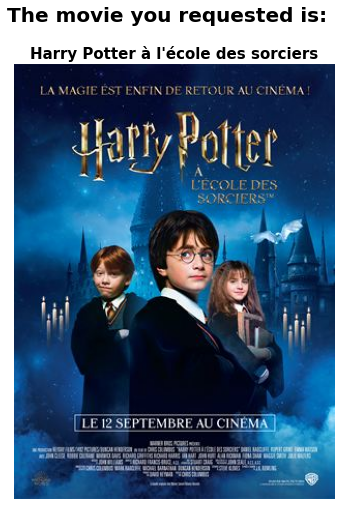

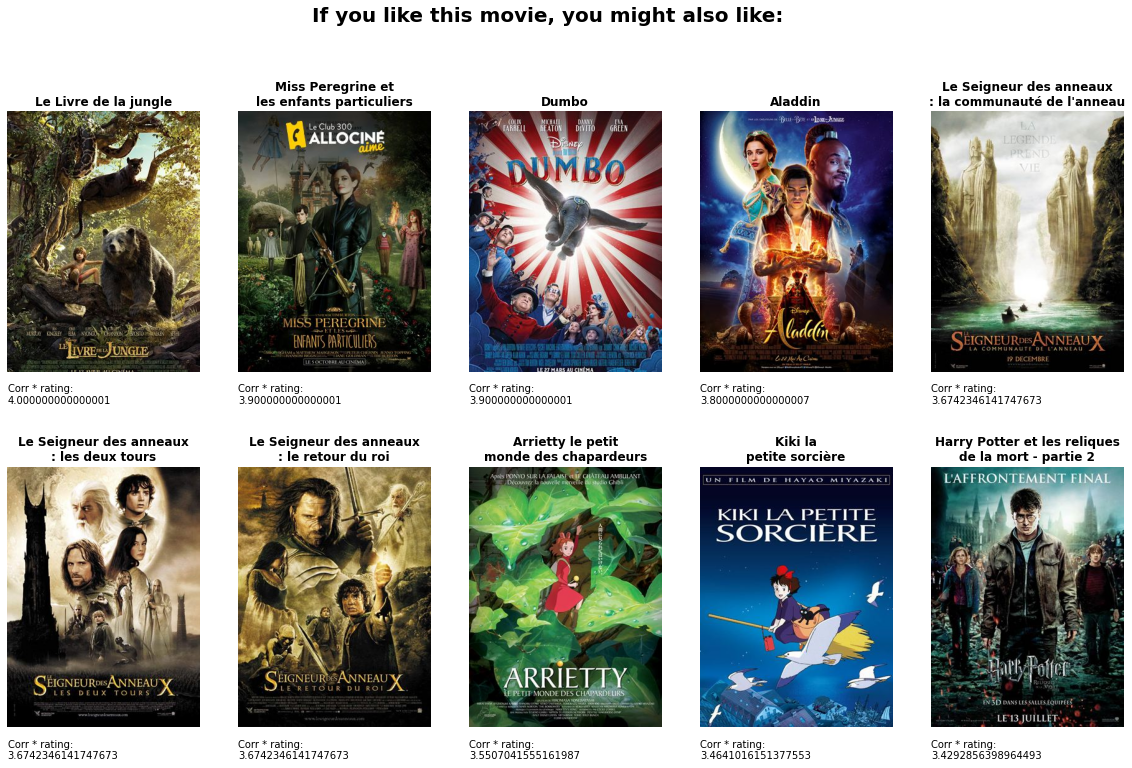

In [168]:
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), cos_sim=cos_sim, nb_recos=10, dummies_df=movies_dummies)
display_recos(m_titles, m_ids)

The similarity between movies is very high, so a lot of movies with the highest similarity are recommended to the user. But depending on the original order of the movies, the order of the recommendations may change and therefore may not be very relevant. This is because we only considered the genres as a comparison criterion. We need to use more features or add a ponderation if we want to have a more accurate recommendation. 

So far, I obtained better recommendation by multiplying the correlation matrix by the movies' ratings. In that way, movies with the same genres will more likely be similar if they have a high rating.

## **Model CB N°2:** Model 1 + tag analysis

In [173]:
# We retrieve only the useful columns for the content-based recommender system
cols_to_keep_2 = ["id", "title", "release_date", "user_rating", "genres", "summary"]

In [174]:
movies_dummies_2 = get_dummies_df(df=movies, keep_cols=cols_to_keep_2, cols_to_dummies=["genres", "tags"])

In [175]:
# We compute the cosine similarity between each movie and multiply it by the user rating.
cos_sim_2 = cosine_similarity(movies_dummies_2.iloc[:,-(movies_dummies_2.shape[1]-len(cols_to_keep_2) - 1):]) * movies_dummies_2.user_rating.values

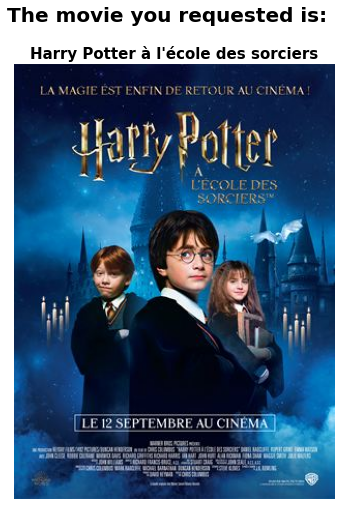

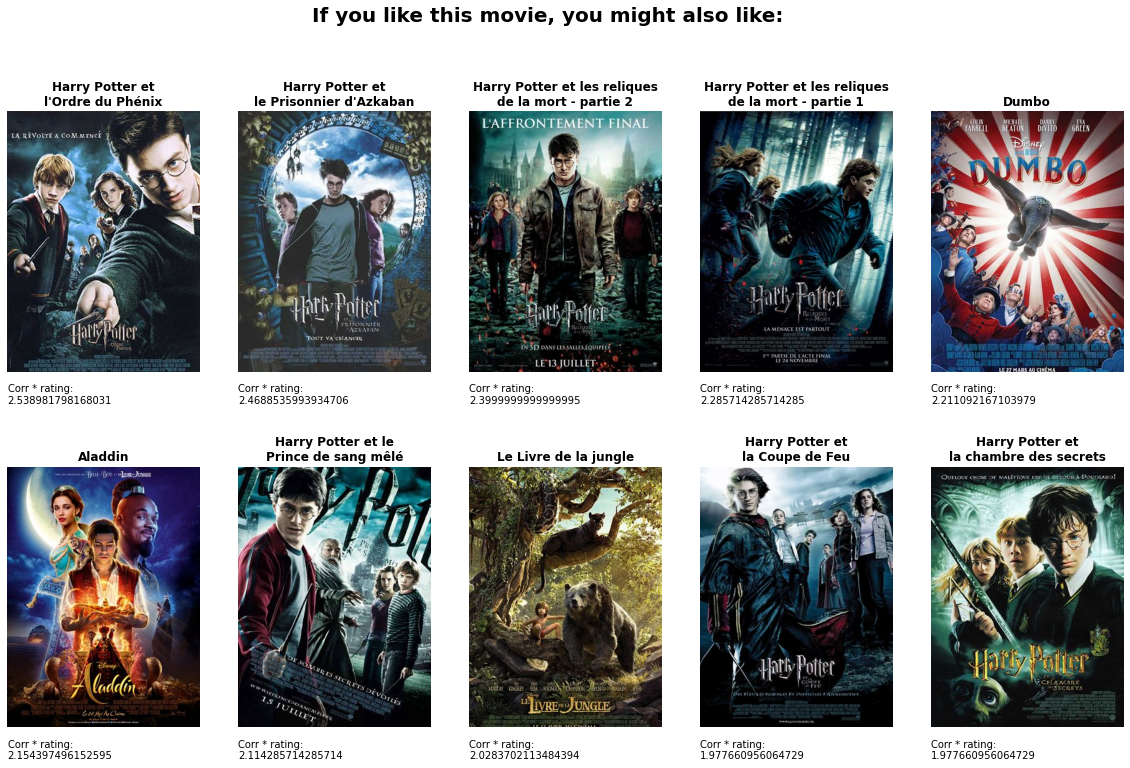

In [176]:
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), cos_sim=cos_sim_2, nb_recos=10, dummies_df=movies_dummies_2)
display_recos(m_titles, m_ids)

In this second model, we used the titles of the movies to help recommend movies that, at first sight, may seem to talk about the same subject. What we notice from this new model is that movies with that share parts of their title are more likely to be recommended to the user, even though they have a lower rating. Moreover, as we decided to remove all punctuation marks and symbols characters, movies like `"X-Men"` will become `"X Men"`, and as both words are considered as stop-words, they will never be used to suggests on purpose other movies from the `"X-Men Saga"`. Movies with titles like `"Le Monde de Narnia : Chapitre 1 - Le lion, la sorcière blanche et l'armoire magique"` won't be affected by this characters removal.

## **Model CB N°3:** Model 1 + actors + directors + nationality

In [181]:
# We retrieve only the useful columns for the content-based recommender system
cols_to_keep_3 = ["id", "title", "release_date", "user_rating", "genres", "actors", "directors", "nationality"]

In [182]:
movies_dummies_3 = get_dummies_df(df=movies, keep_cols=cols_to_keep_3, cols_to_dummies=["genres", "actors", "directors", "nationality"])

In [183]:
# We compute the cosine similarity between each movie and multiply it by the user rating.
cos_sim_3 = cosine_similarity(movies_dummies_3.iloc[:,-(movies_dummies_3.shape[1]-len(cols_to_keep_3) - 1):]) * movies_dummies_3.user_rating.values

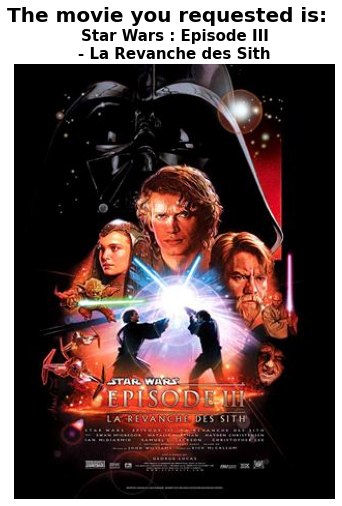

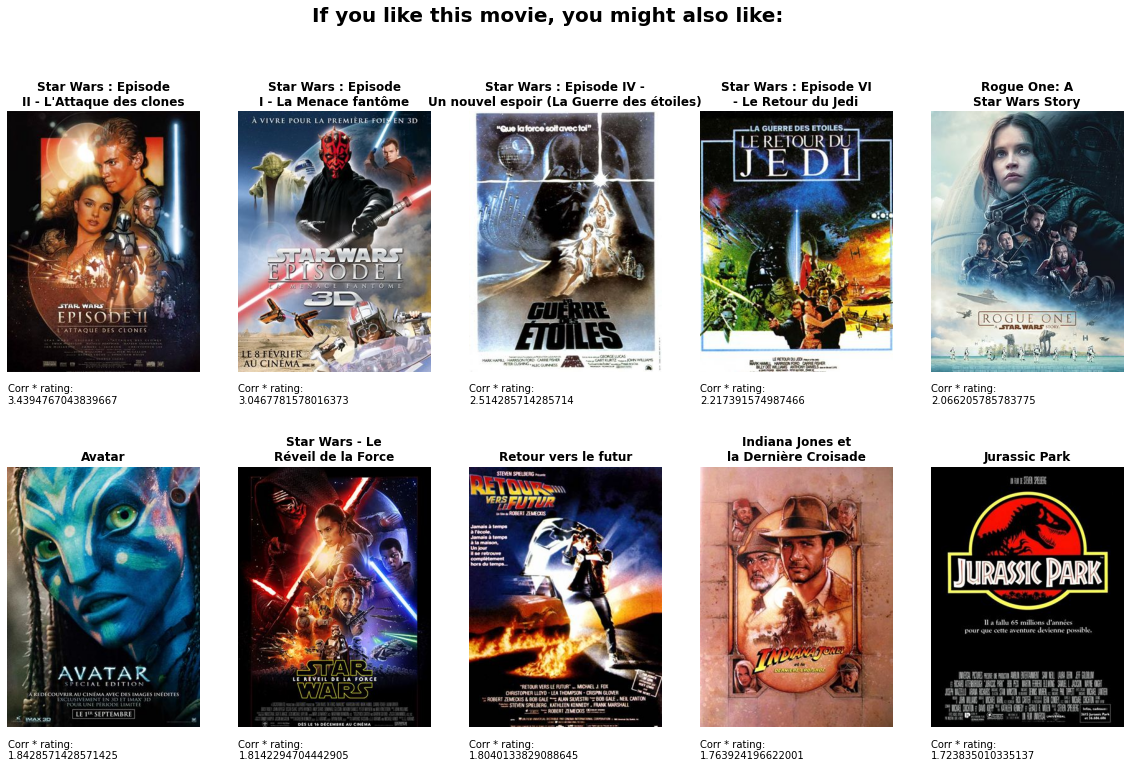

In [224]:
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), cos_sim=cos_sim_3, nb_recos=10, dummies_df=movies_dummies_3)
display_recos(m_titles, m_ids)

# **Collaborative-Filtering (CF)**

## **Model CF N°1:** *Memory-Based CF*

In [221]:
# In the user_movies df, remove users who appears less than 5 times (=> have made less than 5 reviews)
user_movies = user_movies.groupby('user_id').filter(lambda x: len(x) >= 5)

In [222]:
# Pivot table to get the user-movie utility matrix
interactions = user_movies.pivot(index='user_id', columns='movie_id', values='user_rating') 
interactions.describe()

movie_id     1          2          3          4          12         17      \
count     39.000000  31.000000  27.000000  26.000000  45.000000  50.000000   
mean       3.102564   2.983871   3.740741   3.923077   3.655556   3.580000   
std        1.083242   1.106676   0.801085   1.016782   0.928233   1.217894   
min        0.500000   0.500000   1.500000   1.500000   2.000000   0.500000   
25%        2.500000   2.500000   3.500000   3.500000   3.000000   2.625000   
50%        3.000000   3.000000   4.000000   4.000000   3.500000   4.000000   
75%        4.000000   3.500000   4.000000   5.000000   4.500000   4.500000   
max        5.000000   5.000000   5.000000   5.000000   5.000000   5.000000   

movie_id     23         24      27         29      ...    302227  302530  \
count     12.000000  50.000000    3.00  50.000000  ...  9.000000     1.0   
mean       3.291667   3.060000    3.50   3.000000  ...  2.166667     3.0   
std        1.117187   0.945667    0.50   1.460361  ...  1.089725     NaN   
min        1.500000   0.500000    3.00   0.500000  ...  1.000000     3.0   
25%        2.000000   2.500000    3.25   1.625000  ...  1.500000     3.0   
50%        3.750000   3.000000    3.50   3.250000  ...  2.000000     3.0   
75%        4.000000   3.500000    3.75   4.000000  ...  3.000000     3.0   
max        5.000000   5.000000    4.00   5.000000  ...  4.000000     3.0   

movie_id    302598    302673  302792    302942  303281  303310    303312  \
count     6.000000  3.000000     1.0  3.000000     1.0     1.0  2.000000   
mean      3.250000  3.833333     0.5  2.833333     3.5     2.5  2.750000   
std       1.172604  0.763763     NaN  0.288675     NaN     NaN  0.353553   
min       2.000000  3.000000     0.5  2.500000     3.5     2.5  2.500000   
25%       2.250000  3.500000     0.5  2.750000     3.5     2.5  2.625000   
50%       3.250000  4.000000     0.5  3.000000     3.5     2.5  2.750000   
75%       3.875000  4.250000     0.5  3.000000     3.5     2.5  2.875000   
max       5.000000  4.500000     0.5  3.000000     3.5     2.5  3.000000   

movie_id    303478  
count     2.000000  
mean      2.250000  
std       2.474874  
min       0.500000  
25%       1.375000  
50%       2.250000  
75%       3.125000  
max       4.000000  

[8 rows x 7746 columns]

In [70]:
# We standardize the ratings before filling the missing values 
magnitude = np.sqrt(np.square(interactions).sum(axis=1))
interactions = interactions.divide(magnitude, axis='index')
interactions = interactions.fillna(0)

user_similarity = 1-pairwise_distances(interactions, metric='cosine')
item_similarity = 1-pairwise_distances(interactions.T, metric='cosine')

In [71]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1).values.reshape(-1, 1)
        ratings_diff = (ratings - mean_user_rating)
        pred = mean_user_rating + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred
    
user_prediction = predict(interactions, user_similarity, type='user')
item_prediction = predict(interactions, item_similarity, type='item')

In [72]:
index_users = list(interactions.index.values)
index_movie_id = user_movies.movie_id.unique()
index_movies_title = movies[['id','title']].drop_duplicates()

In [73]:
def MB_recommendations(user, prediction, nb_recos=10, index_users = index_users, index_movie_id = index_movie_id, index_movies_title = index_movies_title):
    # Similarity matrix
    user_similarity_df = pd.DataFrame(data=prediction, index=index_users, columns=index_movie_id)
    MB_recos = [] # Initialisation of the list of recommendations
    # If user in the database
    if user in user_similarity_df.index.values:
        score_series = pd.Series(user_similarity_df.loc[user]).sort_values(ascending=False) # We sort the similarity matrix
        top_nbrecos = list(score_series.iloc[0:nb_recos].index) # We select the most similar nb_recos movies to the movies the user has already seen
        # We retrieve the titles of the top nb_recos movies in the list MB_recos and return it
        for i in top_nbrecos:
            MB_recos.append(index_movies_title[index_movies_title.id == i].title.iloc[0])
    else:
        print(f'The required user "{user}" is not in the database.')
    return MB_recos

In [75]:
MB_recommendations("Z20030916115310953701324",user_prediction,10)

['Inglourious Basterds',
 'Du mou dans la gâchette',
 'Les Vétos',
 'Festen',
 'Une affaire de détails',
 'La Route',
 'Astérix et Obélix : Mission Cléopâtre',
 'Onoda - 10 000 nuits dans la jungle',
 'Mommy',
 'Une femme du monde']

In [27]:
MB_recommendations("Z20110828082536017359313",item_prediction,10)

['Assurance sur la mort',
 'Bonnie and Clyde',
 "L'Homme qui voulut être roi",
 'Stand by Me',
 'Le Souffle au coeur',
 'Le Flingueur',
 'Le Septième Sceau',
 'Accattone',
 "L'Homme qui rétrécit",
 'Ben-Hur']

In [28]:
user_movies.user_id.value_counts()

Z20200307184114217262101    5766
Z20051202210829790363634    3554
Z20030916115310953701324    3397
Z20071016041219617269137    3320
Z20110828082536017359313    3076
                            ... 
Z20111105230231077864514       5
Z20081110155902317351288       5
Z20051129215314737543368       5
Z20041129114735730487345       5
Z20100520210355010436628       5
Name: user_id, Length: 2585, dtype: int64